In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install ta-lib
!pip install yfinance

     |████████████████████████████████| 63 kB 2.6 MB/s  eta 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8487 sha256=5345a8d9068a8f3ca28cae30ade55c8b26c96c60e8b836cd8293a7c67c9dcebc
  Stored in directory: /Users/oscar/Library/Caches/pip/wheels/21/c9/66/b41c847de65c7985db52ec21d59996841598b8b0e93f2b9500
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0


In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import talib
import yfinance as y              #線上下載股票
import math
from IPython.display import HTML  #pandas 用html輸出
import warnings                   #把warning訊息屏蔽
warnings.simplefilter(action='ignore', category=Warning)

# 策略一: (RSI線 加入高檔/低檔鈍化)
當RSI線 > 80時，判斷是否為高檔鈍化(呼叫High_state)，直到RSI跌到80以下，出場。

當RSI線 < 20時，判斷是否為低檔鈍化(呼叫down_state)，直到RSI漲到20以上，進場。

(本來要搭配MACD下去做二次確認，但發現報酬率反而更低了。)

In [3]:
def RSI(data):# RSI = 100 × 前N日漲幅的平均值 ÷ ( 前N日漲幅的平均值 + 前N日跌幅的平均值 )，所以RSI這個數字一定會介在0~100中間
    tmp = pd.DataFrame(index=data.index)
    tmp['Diff'] = round(data['Close'].diff(),2)                           #計算Close今天與前一天的價差
    tmp['Rise_only'] = tmp['Diff'].apply(rise)                            #計算價格上升的日子(呼叫 rise)
    tmp['Down_only'] = tmp['Diff'].apply(down)                            #計算價格下跌的日子(呼叫 down)
    tmp['EMA_Rise']  = tmp['Rise_only'].ewm(span=14).mean()               #計算'Rise_only' 14天的指數移動平均
    tmp['EMA_Down']  = tmp['Down_only'].ewm(span=14).mean()               #計算'Down_only' 14天的指數移動平均
    data['RSI'] = tmp['EMA_Rise']/(tmp['EMA_Down']+ tmp['EMA_Rise'])*100  #計算RSI=> (上升平均數/(上升平均數+下跌平均數))*100
    return data
def rise(num):                                                            #當價差是正的時侯回傳價格
    if(num > 0):
        return num
    else:
        return 0
def down(num):                                                            #當價差是負的時侯回傳(-價格)
    if(num < 0):
        return -num
    else:
        return 0  

In [4]:
def High_state(i,data):                                                    #高檔鈍化
    while i < len(data):
        if(data['RSI'][i]<=80):                                            #目標:找到高檔鈍化後，RSI<=80的那天，並且回傳那天
            return i
        i+=1
def down_state(i,data):                                                    #低檔鈍化
    while i < len(data):
        if(data['RSI'][i]>=20):                                            #目標:找到低檔鈍化後，RSI>=20的那天，並且回傳那天
            return i
        i+=1         
def Strategy_1(data):
    up_bound = 80                                                          #上線
    low_bound = 20                                                         #下線
    data = RSI(data)                                                       #計算RSI指標
    #data = MACD(data)
    data['buy'] = np.zeros(data.shape[0])                                  #紀錄買的信號
    data['sell'] = np.zeros(data.shape[0])                                 #紀錄賣的信號
    i=20                                                                   #開始日期
    flag = 0                                                               #判斷是否有錢可以買，0代表可以，1代表不行
    while i < (len(data)-5):
        if(flag==1 and data['RSI'][i] > up_bound):                         #賣點  
            i = High_state(i+1,data)                                       #判斷是否為高檔鈍化
            data.loc[(data.index[i], 'sell')] = 1
            flag =0
            #print('sell |', data.index[i+1], data['Open'][i+1])
        elif(flag==0 and data['RSI'][i] < low_bound):                      #買點 
            i= down_state(i+1,data)                                        #判斷是否為低檔鈍化
            data.loc[(data.index[i], 'buy')] = 1
            flag =1
            #print('buy  |', data.index[i+1], data['Open'][i+1])
        i+=1
    return data
def Strategy_1_draw(data):
    buy, sell = [], []
    for index, row in data.iterrows():
        buy.append(row['Close']*(1-marker_offset) if row['buy'] else np.nan)
        sell.append(row['Close']*(1+marker_offset) if row['sell'] else np.nan)
        
    plots = [
              mpf.make_addplot(data['RSI'], panel = 1, color='blue', ylabel='RSI'),
              mpf.make_addplot(np.full((len(data)), 80), panel = 1, color='#bf5ce0', alpha=0.5),
              mpf.make_addplot(np.full((len(data)), 20), panel = 1, color='#7e3696', alpha=0.5),
              mpf.make_addplot(np.full((len(data)), 50), panel = 1, color='#8eff75', alpha=0.5),]
    
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 100))
        
    mc = mpf.make_marketcolors(up='r',down='g',edge='inherit',wick='inherit',volume='inherit')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    mpf.plot(data,
             type='candle',   
             figscale=1.5,
             scale_width_adjustment=dict(volume=0.4,candle=1.5),
             addplot = plots,
             style=s,
             panel_ratios = (3, 1),
             update_width_config=dict(candle_width=0.5))

# 策略二: (凱特納通道 加入 CCI)

進場: 當中線呈現向上遞增，且CCI>100 or <-100及 收盤價由下往上突破通道上線。

出場: 當中線呈現向下遞減，且CCI>100 or <-100及 收盤價由上往下突破通道下線。

In [5]:
def Keltner(data):#凱特納通道
    data['ATR'] = talib.ATR(data['High'],data['Low'],data['Close'], timeperiod=20)  #計算ATR
    data['EMA_20'] = data['Close'].ewm(span=20).mean()                              #中線:計算EMA_20
    data['Keltner_up'] = data['EMA_20'] + data['ATR']*2                             #計算通道上線: EMA_20 + 2*ATR
    data['Keltner_low'] = data['EMA_20'] - data['ATR']*2                            #計算通道下線: EMA_20 - 2*ATR
    return data
def Strategy_2(data):
    Keltner(data)
    data['CCI'] = talib.CCI(data['High'],data['Low'],data['Close'], timeperiod=20)   #計算CCI
    data['buy'] = np.zeros(data.shape[0])
    data['sell'] = np.zeros(data.shape[0])
    i = 1 
    flag = 0
    while i < (len(data)-1):
        if(flag==0 and data['EMA_20'][i+1] > data['EMA_20'][i]):                     #中線遞增的時候=>進場
            if((data['CCI'][i+1] > 100 or data['CCI'][i+1] <-100) and                #當明天CCI在100~-100(盤整)時不進/出場
               data['Close'][i] < data['Keltner_up'][i] and                          #收盤價由下往上突破上線
               data['Close'][i+1] > data['Keltner_up'][i+1]):
                data.loc[(data.index[i], 'buy')] = 1
                flag=1
                #print('buy  |', data.index[i], data['Open'][i])
        elif(flag==1 and data['EMA_20'][i+1] < data['EMA_20'][i]):                    #中線遞減的時候=>出場
            if((data['CCI'][i+1] > 100 or data['CCI'][i+1] <-100) and                 #當明天CCI在100~-100(盤整)時不進/出場
               data['Close'][i] > data['Keltner_low'][i] and                          #收盤價由上往下突破下線 
               data['Close'][i+1] < data['Keltner_low'][i+1]):
                data.loc[(data.index[i+1], 'sell')] = 1
                flag=0
                #print('sell |', data.index[i], data['Open'][i])
        i+=1
    return data
def Strategy_2_draw(data):
    buy, sell = [], []
    for index, row in data.iterrows():
        buy.append(row['Close']*(1-marker_offset) if row['buy'] else np.nan)
        sell.append(row['Close']*(1+marker_offset) if row['sell'] else np.nan)

    plots = [ mpf.make_addplot(data['Keltner_up'],panel=0, color = 'yellow'),
              mpf.make_addplot(data['Keltner_low'],panel=0, color='lightblue'),
              mpf.make_addplot(data['EMA_20'],panel=0, color = 'blue'),
              mpf.make_addplot(data['CCI'],panel=1, color = 'blue',ylabel='CCI'),
           ]
    
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = 'orange', marker = '^', markersize = 100))
    mc = mpf.make_marketcolors(up='r',down='g',edge='inherit',wick='inherit',volume='inherit')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    mpf.plot(data,
             type='candle',  
             figscale=1.5,
             panel_ratios = (3, 1),
             addplot = plots,
             style=s,
             update_width_config=dict(candle_width=0.5)
            )

# 策略三: (SAR 加入 布林通道)

進場: SAR在股價下方 且股價上漲 且布林通道窄(小於股價的15%)。

出場: SAR在股價上方 且股價下跌 且布林通道寬(大於股價的30%)。

In [6]:
#計算SAR
def cal_sar(data):
    data['SAR']=talib.SAR(data['High'],data['Low'])
    return data

In [7]:
#計算布林通道
def cal_bool(data):
    data['middle'] = data['Close'].rolling(period, min_periods=1).mean()#20MA
    data['upper'] = data['middle'] + data['Close'].rolling(period, min_periods=1).std()*2 #上線
    data['lower'] = data['middle'] - data['Close'].rolling(period, min_periods=1).std()*2 #下線
    return data

In [8]:
'''
交易策略
買:SAR在股價下方 且股價上漲 且布林通道窄(小於股價的15%)
賣:SAR在股價上方 且股價下跌 且布林通道寬(大於股價的30%)
'''
def buy_w4_2(data):
    data['buy'] = np.zeros(data.shape[0])
    data['sell'] = np.zeros(data.shape[0])

    for i in range(period+1,data.shape[0]-1):
        if(data['SAR'][i]<data['Close'][i] 
           and ( data['Close'][i-1]<data['Close'][i])
           and data['upper'][i]<data['Close'][i]*1.15
              ):
            data.loc[(data.index[i+1], 'buy')] = 1

        if(data['SAR'][i]>data['Close'][i]
           and ( data['Close'][i-1]>data['Close'][i])
           and data['upper'][i]>data['Close'][i]*1.3
              ):
            data.loc[(data.index[i+1], 'sell')] = 1
    return data

In [10]:
#畫圖
def draw(data):
    plots = []

    buy, sell = [], []

    for index, row in data.iterrows():
        buy.append(row['Close']*(1-marker_offset) if row['buy'] else np.nan)
        sell.append(row['Close']*(1+marker_offset) if row['sell'] else np.nan)

    plots = [ 
            mpf.make_addplot(data['upper'],color='lime',width=0.5),
            mpf.make_addplot(data['middle'],color='c',width=0.5),
            mpf.make_addplot(data['lower'],color='r',width=0.5),
            mpf.make_addplot(data['SAR'],color='orange',type = 'scatter',marker='.',markersize=10),
    ]
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 100))
    mpf.plot( data, 
                type='candle',       # candlestick chart of stock price
                volume=True,         # plots trading volume as well
                #volume_panel=2,
                figscale=1.5,          # make graph twice bigger
                style='yahoo',       # color scheme using 'yahoo' style
                addplot = plots,
    )   
    return data

In [ ]:
#回測並輸出交易table pt1代表顯示table 0代表不顯示table 兩個stop代表停損
def trade_table(data,pt=1,stop_lost=0,stop_rate=0.1):
    
    money=initial
    
    stock = 0
    gain = 0
    
    detail = [['日期', '買/賣(+/-)', '價格', '價格(稅)', '實際花費', '目前獲利', '剩餘金額']]
    temp_detail=[]
    i=-1
    
    last_buy=0
    
    for index, row in data.iterrows():
        i+=1
        '''#移動停損 最後沒採用
        if(last_buy!=0):
            last_buy = max(last_buy,data.loc[index]['Close'])
        '''
        price=round(data.loc[index]['Close']* 1.001425, 1) 
        if(data.loc[index]['buy'] == 1 and int(money/price)>0 and index != data.index.values[-1]):
            
            data.loc[(index, 'buy')] = 1
            num = math.floor(money/price)                                                  #計算能購買的股數(含稅),無條件捨去小數點
            buy = round(num*price)                                                         #計算實際花費
            money = money-buy
            gain -= buy
            last_buy = data.loc[index]['Close']

            #交易資訊(日期)
            temp_detail.append(str(index)[:11])
            temp_detail.append('+' + str(num))                                             #買賣 num股
            stock += num                                                                   #更新持有股數 +num股
            temp_detail.append(data.loc[index]['Close'])                                   #購買日買入價格: "收盤價"
            temp_detail.append(price)                                                      #抽稅之後的價格(含稅)
            temp_detail.append('-' + str(buy))                                             #實際花費 buy元
            temp_detail.append(gain)                                                       #目前獲利
            temp_detail.append(money)                                                      #剩餘金額
            detail.append(temp_detail)                                                     #紀錄交易資訊至正是表格中
            temp_detail = []           
            
            
        # sell signal or it reach ends
        elif(  ((data.loc[index]['sell'] == 1 or index == data.index.values[-1]) and stock != 0)
             or(stop_lost==1 and last_buy*(1-stop_rate)>data.loc[index]['Close'])#停損
            ):
            data.loc[(index, 'sell')] = 1
            sell = round(data.loc[index]['Close'] * 0.995575 * stock)                      #計算實際收入
            money = money + sell                                                           # 更新 money
            
            gain += sell
            
            last_buy = 0
            #交易資訊(日期)
            temp_detail.append(str(index)[:11])
            temp_detail.append('-' + str(stock))                                           #股票全部賣出
            temp_detail.append(data.loc[index]['Close'])                                   #賣出日賣出價格: "收盤價"
            temp_detail.append(round(data.loc[index]['Close'] * 0.995575))                 #抽稅之後的價格(含稅)
            temp_detail.append('+' + str(sell))                                            #實際收入 (四捨五入到個位數)
            temp_detail.append(gain)                                                       #目前獲利
            temp_detail.append(money)                                                      #剩餘金額
            stock = 0                                                                      #因為全部股票賣出，所以當前股票張數歸零
            detail.append(temp_detail)                                                     #紀錄交易資訊至正是表格中
            temp_detail = []
        
        else:
            data.loc[(index, 'buy')] = 0
            data.loc[(index, 'sell')] = 0
            
    print("支出：", initial, "元")
    print("收入：", money, "元")
    print("淨收益：", money - initial, "元")
    print("投資報酬率：", round(100 * (money - initial) / initial, 2), "%")
    if(pt==1):
        detail = pd.DataFrame(detail)
        display(detail)
    return data
        
            

[*********************100%***********************]  1 of 1 completed
2609.tw


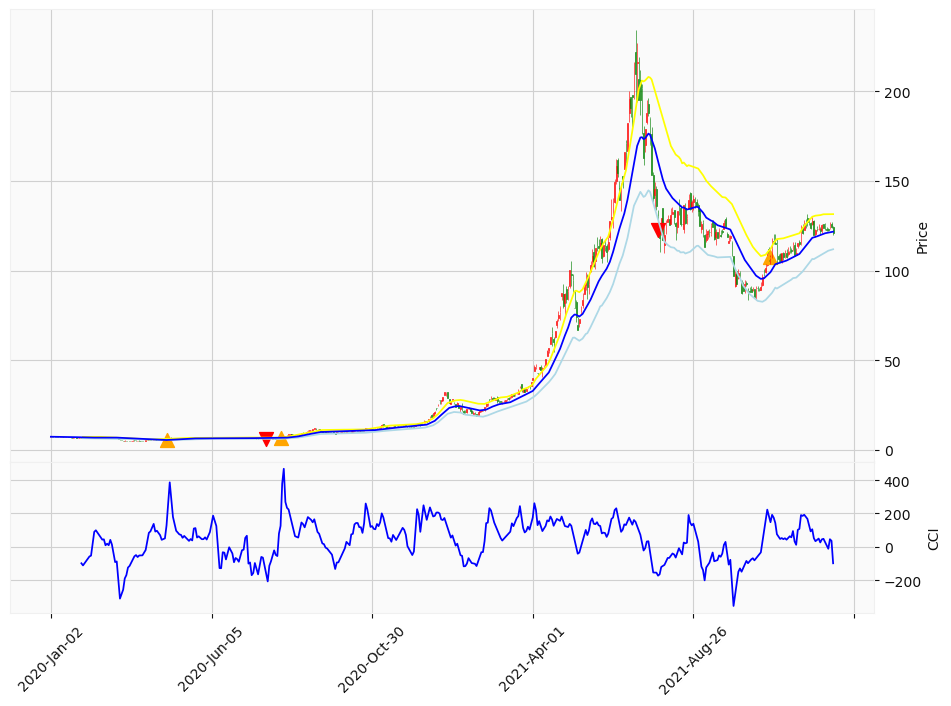

NameError: name 'trade_table' is not defined

In [11]:
##網路上直接下載檔案的版本(測試用)
'''
file=['1101.tw','1102.tw','1216.tw','1301.tw','1303.tw','1326.tw','1402.tw','1476.tw','2002.tw','2105.tw',
      '2207.tw','2301.tw','2303.tw','2308.tw','2317.tw','2324.tw','2330.tw','2354.tw','2357.tw',
      '2382.tw','2395.tw','2408.tw','2409.tw','2412.tw','2474.tw','2801.tw','2881.tw','2882.tw',
      '2883.tw','2884.tw','2885.tw','2886.tw','2887.tw','2890.tw','2892.tw','2912.tw','3008.tw',
      '3045.tw','3481.tw','4904.tw','4938.tw','5880.tw','6505.tw','9904.tw','1227.tw','1319.tw',
      '1440.tw','1504.tw','1536.tw','1589.tw','1590.tw','1605.tw','1707.tw','1717.tw','1722.tw',
      '1723.tw','1789.tw','1802.tw','2015.tw','2049.tw','2059.tw','2101.tw','2103.tw','2106.tw','2201.tw',
      '2231.tw','2313.tw','2327.tw','2345.tw','2347.tw','2352.tw','2353.tw','2355.tw','2360.tw','2362.tw',
      '2376.tw','2377.tw','2379.tw','2383.tw','2385.tw','2392.tw','2449.tw','2451.tw','2498.tw','2501.tw',
      '2542.tw','2603.tw','2609.tw','2610.tw','2615.tw','2618.tw','2707.tw','2809.tw','2812.tw','2823.tw',
      '2834.tw','2845.tw','2849.tw','2903.tw','2915.tw','3034.tw','3037.tw','3044.tw','3189.tw','3231.tw',
      '3673.tw','3702.tw','4958.tw','5522.tw','5871.tw','6176.tw','6239.tw','6269.tw','6285.tw','6414.tw',
      '6415.tw','6456.tw','8150.tw','8454.tw','8464.tw','9907.tw','9910.tw','9914.tw','9917.tw','9921.tw',
      '9933.tw','9938.tw','9945.tw']
'''
#file=['2330.tw','5351.two','5425.two','0050.tw','1440.tw','2027.tw','2603.tw','2609.tw','2449.tw','5234.tw']
file=['2609.tw']

#MA的時間
period=20

#初始金額
initial=500000

#買賣圖案的位置 #預設為0.02
marker_offset=0

for i in file:
    data = y.download(i,start='2020-01-01',end='2021-12-31')
    data = pd.DataFrame(data)
    data = data.drop(['Adj Close'],axis=1)
    print(i)
    #data = cal_bool(data)
    #data = cal_sar(data)
    data = Strategy_2(data)
    Strategy_2_draw(data)
    #data = draw(data)
    #data = buy_w4_1(data)
    data=trade_table(data,1)
    #Strategy_2_draw(data)
    #draw(data)
    

In [12]:
##策略1
#載入資料夾所有csv(當天要用的版本)

import os
path = os.getcwd() # 取得此檔案當前的工作路徑
print(path)
list_csv = os.listdir(path) # 取得此路徑中的所有檔案
print(list_csv)
file = [file for file in list_csv if '.csv' in file] # 過濾出股價檔(.csv)

#初始金額
initial=500000

#買賣圖案的位置 #預設為0.02
marker_offset=0

for i in file:
    print(i)
    data = pd.read_csv(i)
    data = pd.DataFrame(data)
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d")
    data = data.set_index('Date') 
    
    data = Strategy_1(data)
    Strategy_1_draw(data)
    data=trade_table(data,1)


/Users/oscar/Desktop/stock_project/Week17_final_report/期末報告
['final_report_第二組', '第五組期末報告.pptx', '.DS_Store', '第一組期末報告.pptx', 'final_report_第五組.ipynb', 'final_report_第四組.ipynb', '第二組期末報告.docx', '~$第五組期末報告.pptx', 'final_report_第七組.ipynb', '第四組期末報告.pptx', '第三組期末報告.pdf', '.ipynb_checkpoints', 'final_report_第一組.ipynb', 'final_report_範例程式碼.ipynb', 'final_report_第六組.ipynb', '第七組期末報告.pptx']


In [13]:
##策略2
#載入資料夾所有csv(當天要用的版本)

import os
path = os.getcwd() # 取得此檔案當前的工作路徑
print(path)
list_csv = os.listdir(path) # 取得此路徑中的所有檔案
print(list_csv)
file = [file for file in list_csv if '.csv' in file] # 過濾出股價檔(.csv)


#初始金額
initial=500000

#買賣圖案的位置 #預設為0.02
marker_offset=0

for i in file:
    print(i)
    data = pd.read_csv(i)
    data = pd.DataFrame(data)
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d")
    data = data.set_index('Date')
    
    data = Strategy_2(data)
    Strategy_2_draw(data)
    data=trade_table(data,1)


/Users/oscar/Desktop/stock_project/Week17_final_report/期末報告
['final_report_第二組', '第五組期末報告.pptx', '.DS_Store', '第一組期末報告.pptx', 'final_report_第五組.ipynb', 'final_report_第四組.ipynb', '第二組期末報告.docx', '~$第五組期末報告.pptx', 'final_report_第七組.ipynb', '第四組期末報告.pptx', '第三組期末報告.pdf', '.ipynb_checkpoints', 'final_report_第一組.ipynb', 'final_report_範例程式碼.ipynb', 'final_report_第六組.ipynb', '第七組期末報告.pptx']


In [14]:
##策略3
#載入資料夾所有csv(當天要用的版本)

import os
path = os.getcwd() # 取得此檔案當前的工作路徑
print(path)
list_csv = os.listdir(path) # 取得此路徑中的所有檔案
print(list_csv)
file = [file for file in list_csv if '.csv' in file] # 過濾出股價檔(.csv)

#MA的時間
period=20

#初始金額
initial=500000

#買賣圖案的位置 #預設為0.02
marker_offset=0

for i in file:
    print(i)
    data = pd.read_csv(i)
    data = pd.DataFrame(data)
    data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d")
    data = data.set_index('Date')  
    
    data = cal_bool(data)
    data = cal_sar(data)
    data = buy_w4_2(data)
    data=trade_table(data,1,1)
    draw(data)


/Users/oscar/Desktop/stock_project/Week17_final_report/期末報告
['final_report_第二組', '第五組期末報告.pptx', '.DS_Store', '第一組期末報告.pptx', 'final_report_第五組.ipynb', 'final_report_第四組.ipynb', '第二組期末報告.docx', '~$第五組期末報告.pptx', 'final_report_第七組.ipynb', '第四組期末報告.pptx', '第三組期末報告.pdf', '.ipynb_checkpoints', 'final_report_第一組.ipynb', 'final_report_範例程式碼.ipynb', 'final_report_第六組.ipynb', '第七組期末報告.pptx']
